# Image analysis and processing - Spring 2022
## Final Project Assignment
#### Ioannis-Christos Kandias (7115152100018, Big Data & Artificial Intelligence)

#### Alexandros Tavernarakis (7115152100016,  Big Data & Artificial Intelligence)

The goal of this final project is to use and compare classical machine learning and neural network algorithms on a classification problem. 

We will work on the Chest X-Ray Image (Pneumonia) kaggle dataset found on https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia. The dataset contains 3 subsets (train, test, validatation) with images depicting healthy (labeled NORMAL) and pneumonia-affected (labeled PNEUMONIA) lungs. 

By exploring and visualizing the dataset we observe that to a non-medical-trained eye all the images appear the same. We will therefore apply machine learning algorithms on an effort to build an efficient classifier. 

This notebook is split into three main sections:

1. loading, exploring and vizualizing the dataset

2. applying some image pre-processing along with classical machine learching algorithms and evaluating the results

3. applying a convolutional neural network architecture and evaluating the results

This notebook was written on the online colab platform. To run this notebook one needs to download a token from the kaggle website in order to be able to load the dataset into this notebook.

### 0a. Load data from kaggle

In [6]:
#! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 2.27G/2.29G [00:10<00:00, 208MB/s]
100% 2.29G/2.29G [00:10<00:00, 226MB/s]


In [7]:
%%capture
! unzip chest-xray-pneumonia


### 0b. Load libraries

In [8]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
import keras.layers as layers
import keras.models as m
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
#from keras.utils import plot_model
#import tf.keras.util as mod
import pandas as pd
from PIL import Image
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import random
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import seaborn as sn
from sklearn import metrics
import pickle

### 1. Explore the data and define appropriate classes

In [9]:
path = "chest_xray/"
train_path_NORMAL = path + "train/NORMAL/*.jpeg"
train_path_PNEUMONIA = path + "train/PNEUMONIA/*.jpeg"

train_files_NORMAL = glob.glob(train_path_NORMAL)
train_files_PNEUMONIA = glob.glob(train_path_PNEUMONIA)

test_files_NORMAL = glob.glob(path + "test/NORMAL/*.jpeg")
test_files_PNEUMONIA = glob.glob(path + "test/PNEUMONIA/*.jpeg")

val_files_NORMAL = glob.glob(path + "val/NORMAL/*.jpeg")
val_files_PNEUMONIA = glob.glob(path + "val/PNEUMONIA/*.jpeg")

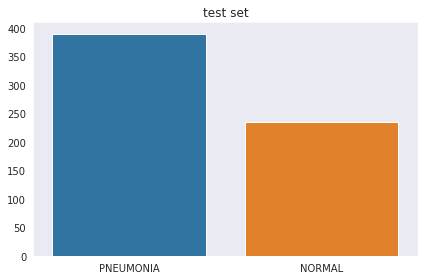

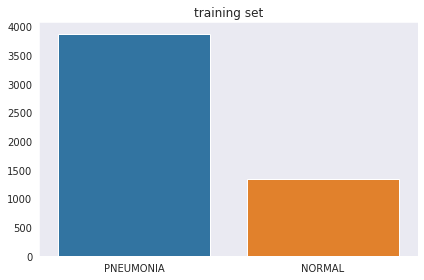

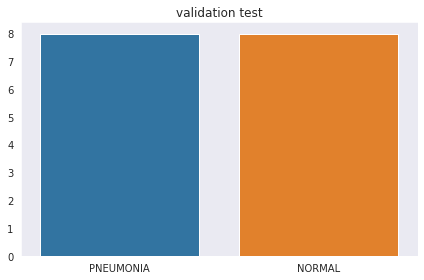

In [10]:
def count_files_bar(path, title):
    dirs = os.listdir(path)
    number_of_files = []
    labels = []
    for directory in dirs:
        files_path = os.path.join(path, directory)
        number_of_files.append(len(os.listdir(files_path)))
        labels.append(directory)
        
    sns.set_style('dark')
    sns.barplot(y=number_of_files, x=labels)
    plt.title(title)
    plt.tight_layout()
    plt.show()

count_files_bar("chest_xray/test", 'test set')
count_files_bar("chest_xray/train", 'training set')
count_files_bar("chest_xray/val", 'validation test')

There are 3 subsets all of which contain 2 categories with labels NORMAL and PNEUMONIA, corresponding to healthy and pneumonia-infected chestrays, respectively. The three subsets are:

* test set: there is an important imbalance between the two categories as there are far less NORMAL chestrays than PNEUMONIA chestrays (~250 against ~400). 
* training set: the same imbalance occurs in the training set as well (~1500 against ~4000).
* validation set: whereas the validation test is very well balanced it is very small (16 total chestrays)
    
Comments: The imbalance between the two categories could prove to be crucial for the training of our models. As there much fewer "NORMAL" images than "PNEUMONIA" in the training set, a risk of overfitting arises. We will tackle this problem by performing a data augmentation by using the capabilites of the ImageDateGenerator library.
    
In the following, and in an effort to better "feel" the data, we load and print
on the screen 12 random images from each category of the training set. 

We observe a series of chest x rays of persons that are either healhty or infected with pneumonia. Obviously, to an untrained eye, all the x-rays seem all too similar. During this exercise, we will leverage some machine learning algorithms (classical algorithms along with a neural networks) to classify these images into two different classes: "Normal" and "Pneumonia".
    

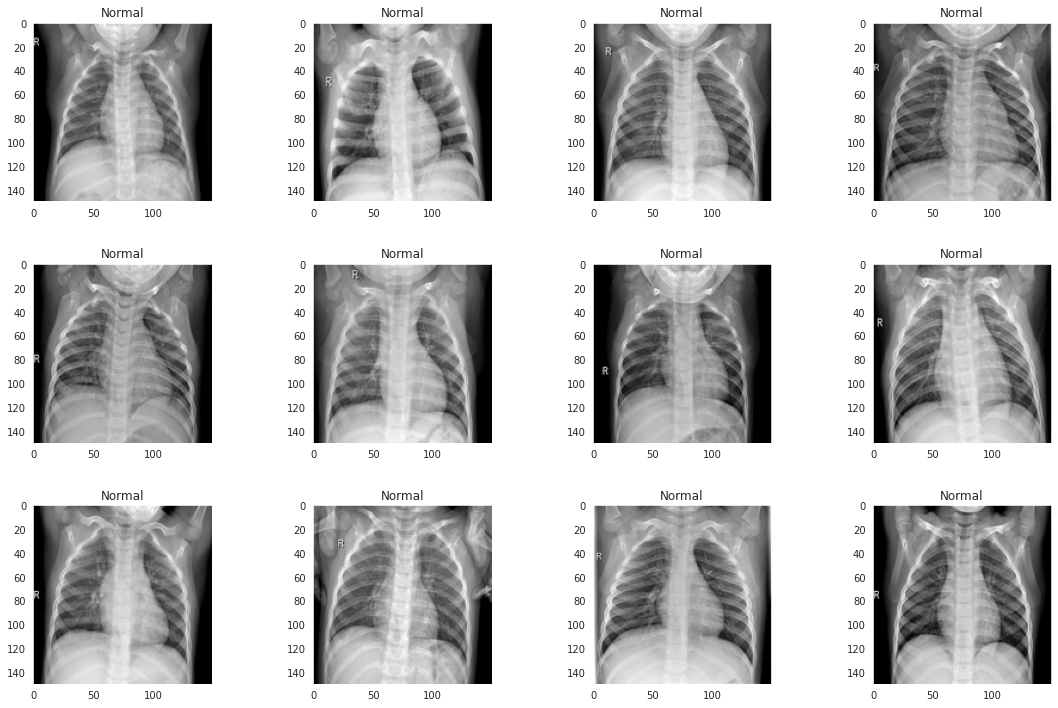

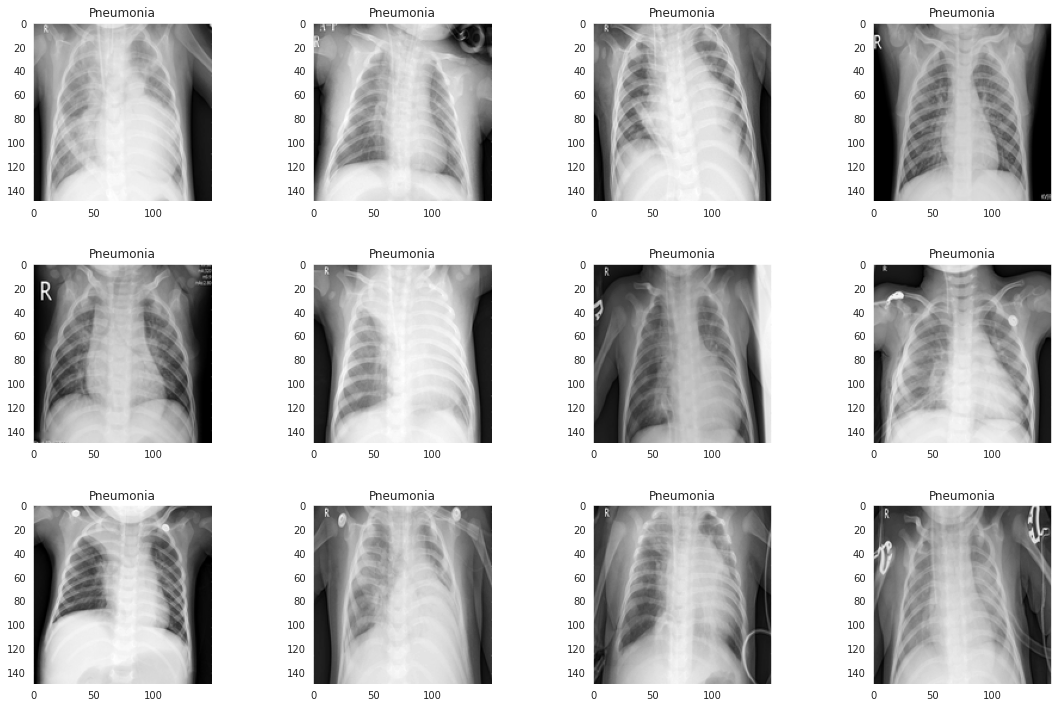

In [11]:
# choose 12 random images from each category of the training set
random_normal_train = np.random.choice(train_files_NORMAL, size= 12, replace = False, p=None)
random_pneumonia_train = np.random.choice(train_files_PNEUMONIA, size= 12, replace = False, p=None)


random_normal_train_images = np.zeros(12, dtype=object)
random_pneumonia_train_images = np.zeros(12, dtype=object)

# read the 12 images and resize to 150x150
for i in range(12):
        img = Image.open(os.path.join( random_normal_train[i]))
        img = img.resize((150,150), Image.ANTIALIAS)
        random_normal_train_images [i]=img
for i in range(12):
        img = Image.open(os.path.join(random_pneumonia_train[i]))
        img = img.resize((150,150), Image.ANTIALIAS)
        random_pneumonia_train_images [i]=img

# plot the images in a gallery
def plot_gallery(images, title):
    """Helper function to plot a gallery of the 12 images"""
    plt.figure(figsize=(3.8 * 4, 3.4 * 3))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(title)
        

plot_gallery(random_normal_train_images, 'Normal')
plot_gallery(random_pneumonia_train_images, 'Pneumonia')
plt.show()

### 2. Classical Machine Learning Algorithms

In this section, supervised learning methods will be implemented as the data is labelled and there is no need for unsupervised learning (where it is more difficult to interpret the results).

Below is presented the best approach from the tried ones which is a HOG feature descriptor with an SVM classifier.

### Preprocessing

First, we will read the in the training, test and validation sets (all the images are grayscale), then we will resize every image to 128x128 pixels for fitting the cells to the HOG descriptor. 

In [12]:
#Open, resize, convert to array, reshape and save to an array
normal_train = np.zeros(len(train_files_NORMAL), dtype=object)
for dirname, _, filenames in os.walk("chest_xray/train/NORMAL"):
    for i in range(len(filenames)):
        img = Image.open(os.path.join(dirname, filenames[i]))
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        img.reshape((128,128,-1))
        normal_train[i]=img

pneumonia_train=np.zeros(len(train_files_PNEUMONIA),dtype=object)
for dirname, _, filenames in os.walk("chest_xray/train/PNEUMONIA"):
    for i in range(len(filenames)):
        img = Image.open(os.path.join(dirname, filenames[i]))
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        img.reshape((128,128,-1))
        pneumonia_train[i]=img

normal_test=np.zeros(len(test_files_NORMAL),dtype=object)
for dirname, _, filenames in os.walk("chest_xray/test/NORMAL"):
    for i in range(len(filenames)):
        img = Image.open(os.path.join(dirname, filenames[i]))
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        img.reshape((128,128,-1))
        normal_test[i]=img        

pneumonia_test=np.zeros(len(test_files_PNEUMONIA),dtype=object)
for dirname, _, filenames in os.walk("chest_xray/test/PNEUMONIA"):
    for i in range(len(filenames)):
        img = Image.open(os.path.join(dirname, filenames[i]))
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        img.reshape((128,128,-1))
        pneumonia_test[i]=img
        
normal_val=np.zeros(len(val_files_NORMAL),dtype=object)
for dirname, _, filenames in os.walk("chest_xray/val/NORMAL"):
    for i in range(len(filenames)):
        img = Image.open(os.path.join(dirname, filenames[i]))
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        img.reshape((128,128,-1))
        normal_val[i]=img        

pneumonia_val=np.zeros(len(val_files_PNEUMONIA),dtype=object)
for dirname, _, filenames in os.walk("chest_xray/val/PNEUMONIA"):
    for i in range(len(filenames)):
        img = Image.open(os.path.join(dirname, filenames[i]))
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        img.reshape((128,128,-1))
        pneumonia_val[i]=img

And to inspect a random preprocessed image from the training test:

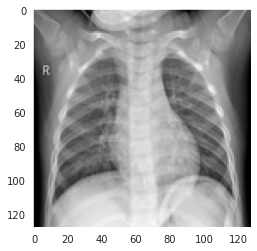

In [13]:
plt.imshow(normal_train[2], cmap=plt.cm.gray)
plt.show()

### Feature extraction using the HOG feature descriptor

In the code below we use the hog funtion from skimage for feature extraction from our images. Please note that different configuration for the hog function had been tested (data not shown) for example different values for pixels per cell and cells per block as well as square root normalization, without significant differences (regarding the model performance) from the configuration below.

In [14]:
# just a parameter to change pixels per cell easily
ppc = 8

normal_hog_train_images = np.zeros(len(normal_train),dtype=object)
normal_hog_train_features = np.zeros(len(normal_train),dtype=object)

pneumonia_hog_train_images = np.zeros(len(pneumonia_train),dtype=object)
pneumonia_hog_train_features = np.zeros(len(pneumonia_train),dtype=object)

normal_hog_test_images = np.zeros(len(normal_test),dtype=object)
normal_hog_test_features = np.zeros(len(normal_test),dtype=object)

pneumonia_hog_test_images = np.zeros(len(pneumonia_test),dtype=object)
pneumonia_hog_test_features = np.zeros(len(pneumonia_test),dtype=object)

normal_hog_val_images = np.zeros(len(normal_val),dtype=object)
normal_hog_val_features = np.zeros(len(normal_val),dtype=object)

pneumonia_hog_val_images = np.zeros(len(pneumonia_val),dtype=object)
pneumonia_hog_val_features = np.zeros(len(pneumonia_val),dtype=object)


# Feature extraction using the HOG feature descriptor
for i in range(len(normal_train)):
    fd, hog_image = hog(normal_train[i], orientations=8, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(2, 2), visualize=True)
    normal_hog_train_images[i] = hog_image
    normal_hog_train_features[i] = fd

    
for i in range(len(pneumonia_train)):
    fd, hog_image = hog(pneumonia_train[i], orientations=8, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(2, 2), visualize=True)
    pneumonia_hog_train_images[i] = hog_image
    pneumonia_hog_train_features[i] = fd
    
for i in range(len(normal_test)):
    fd, hog_image = hog(normal_test[i], orientations=8, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(2, 2), visualize=True)
    normal_hog_test_images[i] = hog_image
    normal_hog_test_features[i] = fd

    
for i in range(len(pneumonia_test)):
    fd, hog_image = hog(pneumonia_test[i], orientations=8, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(2, 2), visualize=True)
    pneumonia_hog_test_images[i] = hog_image
    pneumonia_hog_test_features[i] = fd

for i in range(len(normal_val)):
    fd, hog_image = hog(normal_val[i], orientations=8, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(2, 2), visualize=True)
    normal_hog_val_images[i] = hog_image
    normal_hog_val_features[i] = fd

    
for i in range(len(pneumonia_val)):
    fd, hog_image = hog(pneumonia_val[i], orientations=8, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(2, 2), visualize=True)
    pneumonia_hog_val_images[i] = hog_image
    pneumonia_hog_val_features[i] = fd

And to inspect what the HOG features for a random image from the training set look like:

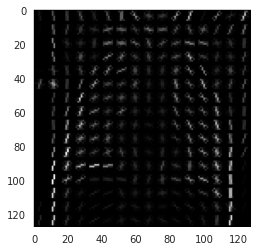

In [15]:
plt.imshow(normal_hog_train_images[150], cmap=plt.cm.gray)
plt.show()

### Creating the train and validation datasets

The code below defines the labels for the 3 sets. We set 0 for normal and 1 for pneumonia:

In [16]:
normal_train_labels = np.array([0 for i in range(len(normal_train))])
pneumonia_train_labels = np.array([1 for i in range(len(pneumonia_train))])
train_labels = np.concatenate((normal_train_labels,pneumonia_train_labels))

normal_test_labels = np.array([0 for i in range(len(normal_test))])
pneumonia_test_labels = np.array([1 for i in range(len(pneumonia_test))])
test_labels = np.concatenate((normal_test_labels,pneumonia_test_labels))

normal_val_labels = np.array([0 for i in range(len(normal_val))])
pneumonia_val_labels = np.array([1 for i in range(len(pneumonia_val))])
val_labels = np.concatenate((normal_val_labels,pneumonia_val_labels))

The code below centers and scales the features using the StandardScaler() function from scikit-learn:

In [17]:
from sklearn.preprocessing import StandardScaler

# convert the arrays to lists
normal_hog_train_features=normal_hog_train_features.tolist()
pneumonia_hog_train_features=pneumonia_hog_train_features.tolist()
normal_hog_test_features=normal_hog_test_features.tolist()
pneumonia_hog_test_features=pneumonia_hog_test_features.tolist()

# center and scale
scaler = StandardScaler().fit(normal_hog_train_features+pneumonia_hog_train_features)
normal_hog_train_features = scaler.transform(normal_hog_train_features)
pneumonia_hog_train_features = scaler.transform(pneumonia_hog_train_features)

scaler_test = StandardScaler().fit(normal_hog_test_features+pneumonia_hog_test_features)
normal_hog_test_features = scaler_test.transform(normal_hog_test_features)
pneumonia_hog_test_features = scaler_test.transform(pneumonia_hog_test_features)

# stack the arrays together
train_set = np.vstack((normal_hog_train_features,pneumonia_hog_train_features))
test_X = np.vstack((normal_hog_test_features,pneumonia_hog_test_features))

We shuffle the data (although it won't play a crucial role to the obtained results, it will just make them more presentables).

In [18]:
temp_list_1 = list(zip(train_set, train_labels))
random.shuffle(temp_list_1)
train_set, train_labels = zip(*temp_list_1)
train_set = np.asarray(train_set)
train_labels = np.asarray(train_labels)


temp_list_2 = list(zip(test_X, test_labels))
random.shuffle(temp_list_2)
test_X, test_labels = zip(*temp_list_2)
test_X = np.asarray(test_X)
test_labels = np.asarray(test_labels)

### Training

In the part below we will train the  SVM classifier. We will use the GridSearchCV function from scikit-learn that also performs grid-search over a pre-defined parameter grid using cross-validation to try and find the best parameters for our estimator. 

In [19]:
# define the parameter grid for the grid search
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf']}
  ]


# Train and perform grid search
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1)

grid.fit(train_set, train_labels) 
 
# print best parameter after tuning 
print(grid.best_params_) 

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'C': 10, 'kernel': 'rbf'}


Then we can use the estimator with the best parameters to predict the classes of the test set and print a classification report:

### Evaluation

In [20]:
# predict the test set
grid_predictions = grid.predict(test_X) 
   
# print classification report 
print(classification_report(test_labels, grid_predictions, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.93      0.49      0.64       234
   Pneumonia       0.76      0.98      0.86       390

    accuracy                           0.79       624
   macro avg       0.84      0.73      0.75       624
weighted avg       0.82      0.79      0.77       624



And we can also print the confusion matrix:

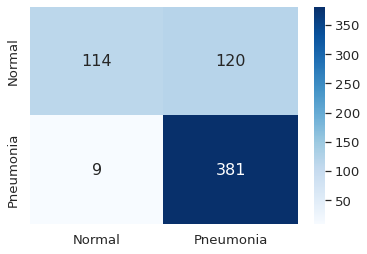

In [21]:
#calculate confusion matrix
cm = metrics.confusion_matrix(test_labels, grid_predictions)

#convert to data frame and set labels
df_cm = pd.DataFrame(cm, index = ['Normal', 'Pneumonia'] , columns = ['Normal', 'Pneumonia'])

sn.set(font_scale=1.2)#for label size
sn.heatmap(df_cm, cmap= "Blues", annot=True,annot_kws={"size": 16}, fmt="g")
plt.show()

In [22]:
# print accuracy and predictions for the first ten data
print('Test Accuracy of SVC = ', round(grid.score(test_X, test_labels), 4))
n_predict = 10
print('My SVC predicts: ', grid.predict(test_X[0:n_predict]))
print('For these',n_predict, 'labels: ', test_labels[0:n_predict])

Test Accuracy of SVC =  0.7933
My SVC predicts:  [1 0 1 0 0 1 1 0 0 1]
For these 10 labels:  [1 0 1 0 0 0 1 1 0 1]


From the results, we can see that we have obtain a very good accuracy, about 79%. However, the most substantial part in the above results lies in the fact that the model **is biased towards not making mistakes to people that have pneumonia and classify them as normal cases**, which is something that is extremely desired. In this spirit, it gets an accuracy of 98% in the pneumonia cases (in such problems, a good recall value is expected). Also, the model has a very good precision at the normal cases, so if the model judges that someone doesn't have pneumonia, then he most likely doesn't have.<br> So, in these crucial directions the model has performed very well. <br><br> 

### Save the model
We save the data for later use because the sklearn library was used for the trainning (which doesn't use GPU accelerator so every trainning took a lot of time). With this way we were able to compare and retrieve rapidly the trained models.

In [23]:
# Save the data for later use

#data_file = 'hog_svm_grid2.p'

#if not os.path.isfile(data_file):
#    with open(data_file, 'wb') as pfile:
#        pickle.dump(grid, pfile, pickle.HIGHEST_PROTOCOL)

#print('Data saved in pickle file')

In [25]:
# grid = pickle.load( open("hog_svm_grid2.p", "rb" ) )

Now, let's see how the neural networks will perform which in general are more prone to better results if things done right.

## 3. Neural Network Algorithms

For this part of this exercise we will use a Convolutional Neural Network (CNN) in order to get even better classification results. 

A CNN is an artificial neural network that has the ability to automaticaly detect patterns in the images and has the additional advantage that no image pre-processing is necessary by the uses. 

The difficulty of setting up a CNN lies in the correct fine tuning of its papameters



### Creating the train and validation datasets

As mentioned in the introduction the training dataset is imbalanced and this can lead to our CNN to learn "very well" the details of the images (i.e. overfitting). We will use data augmentation to solve this problem. mage Augmentation expands the size of the dataset by creating a modified version of the existing training set images that helps to increase dataset variation and ultimately improve the ability of the model to predict new images. 

Below, we use the ΙmageDataGenerator library to generate the training set by rescaling the scales array of the original image pixel values between [0,1], by performing a shear transformation, a zoom enlargement, a horizontal flip of some of the images and a random rotation of the images. 



In [26]:
train_datagen = ImageDataGenerator(rescale = 1. / 255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 0.2)

directory = path + "train"
train_generator = train_datagen.flow_from_directory(
        directory = directory,
        batch_size = 64,
        seed = 42,
        shuffle = True,
        class_mode = 'binary',
        target_size = (100, 100),
)

Found 5216 images belonging to 2 classes.


Similarly we create the validation dataset, although no data augmentation is applied. 

In [27]:
val_datagen = ImageDataGenerator(rescale = 1. / 255.)
directory = path + "val"
val_generator = val_datagen.flow_from_directory(
        directory = directory,
        batch_size = 64,
        seed = 42,
        shuffle = True,
        class_mode = 'binary',
        target_size = (100, 100),
)

Found 16 images belonging to 2 classes.


### CNN architecture

We have followed the basic guidelines of the architecture of a CNN, as given during the course lectures:

* begin with a lower filter value
* add a series of convolutional layers (Conv2D) 
* follow each Conv2D layer by a layer of BatchNormalization and MaxPooling
* optionally, Dropout some weights at every layer (this is done empeirically)
* flatten the output of the Conv2D layers
* add Dense layers to reduce the dimensions
* use a sigmoid activation function at the output (appropriate for a binary classifier)

In [28]:
def CNN():
    #set up the model
    model = Sequential()

    # 1st convolutional layer
    model.add(Conv2D(32, 
                     (3,3), 
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=(100,100,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2 , padding='same'))

    # 2nd convolutional layer
    model.add(Conv2D(64, 
                     (3,3), 
                     strides=1, 
                     padding='same', 
                     activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))

    # 3rd convolutional layer
    model.add(Conv2D(64, 
                     (3,3), 
                     strides=1, 
                     padding='same',
                     activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    # 4th convolutional layer
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    # 5th convolutional layer
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())

    # final layers
    model.add(Dense(units = 64 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
                  
    return model

classifier = CNN()

# compile the model
classifier.compile(optimizer = "rmsprop",
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

# print a summary of the model
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 64)       2

In [ ]:
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.utils import plot_model

# plot_model(CNN,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

### Learning rate parameter

The learning rate is a crucial parameter when training a neural network. Generally speaking, a large learning rate will allow a model to lear faster. However, if one sets a too large value will result in weight updates that are too large and the performance of the model will oscillate over training epocs. 

Therefore, it is a good practice to reduce learning rate when a metric has stopped improving as models often benefit from reducing the learning rate by a factor of 2–10 once learning stagnates. To this end, we will leverage the ReduceLROnPlateau function which automatically tunes the learning rate parameter at each epochs. This callback monitors a quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.


In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [30]:
epochs = 10
history = classifier.fit(train_generator, 
                         epochs = epochs, 
                         steps_per_epoch = len(train_generator),
                         validation_data = val_generator, 
                         validation_steps = len(val_generator),
                         callbacks = [learning_rate_reduction])

Epoch 1/10
82/82 [==============================] - 83s 837ms/step - loss: 0.4987 - accuracy: 0.8374 - val_loss: 15.3343 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
82/82 [==============================] - 58s 713ms/step - loss: 0.2421 - accuracy: 0.9016 - val_loss: 31.0720 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
82/82 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9250
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 59s 723ms/step - loss: 0.2128 - accuracy: 0.9250 - val_loss: 40.9636 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
82/82 [==============================] - 66s 807ms/step - loss: 0.1225 - accuracy: 0.9544 - val_loss: 47.9265 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
82/82 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9615
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
82/82 [==============================] 

### Evaluation
Let’s first visualize the progress of all metrics throughout the total epochs lifetime



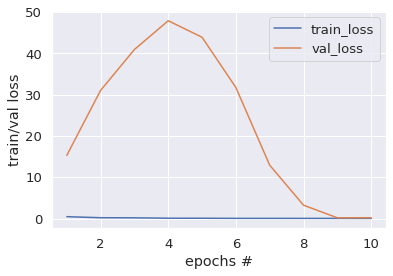

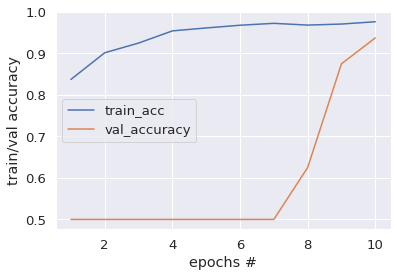

In [32]:
hist = history.history

ep = range(1, epochs+1)
plt.figure()
plt.plot(ep, hist['loss'], label='train_loss')
plt.plot(ep, hist['val_loss'], label='val_loss')
plt.ylabel('train/val loss')
plt.xlabel('epochs #')
plt.legend()
# plt.savefig('loss2.png')

plt.figure()
plt.plot(ep, hist['accuracy'], label='train_acc')


plt.plot(ep, hist['val_accuracy'], label='val_accuracy')
plt.ylabel('train/val accuracy')
plt.xlabel('epochs #')
plt.legend()
# plt.savefig('val_accuracy2.png')

Create the testing dataset and fit our model to make predictions over testing set. No data augmentation necessary.

In [33]:
test_datagen = ImageDataGenerator(rescale = 1. / 255.)
directory = path + "test"
test_generator = test_datagen.flow_from_directory(
        directory = directory,
        batch_size = 64,
        seed = 42,
        shuffle = False,
        class_mode = 'binary',
        target_size = (100, 100),
)

Found 624 images belonging to 2 classes.


The predict function gives the activation values. As we are using a sigmoid activation values we convert the activation values to the actual model prediction using the value 0.5 as threshold. 

In [34]:
def activations2predictions(activations):
  predictions = []
  for i in activations:
    if i < 0.5: # sigmoid activation function threshold
      predictions.append(0)
    else:
      predictions.append(1)
  return predictions

activations = classifier.predict(test_generator)
predictions = activations2predictions(activations)

Create a classification report and plot the confusion matrix

              precision    recall  f1-score   support

      normal       0.92      0.89      0.90       234
   pneumonia       0.93      0.95      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



Text(0.5, 1.0, 'Confusion matrix')

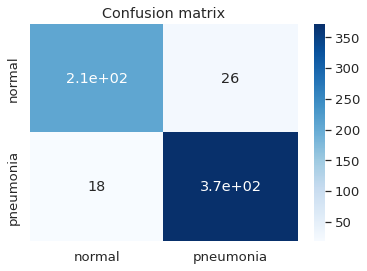

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = test_generator.labels
y_pred = predictions
target_names = ['normal', 'pneumonia']

print(classification_report(y_true, y_pred, target_names=target_names))
conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, 
            cmap= "Blues", 
            annot=True, 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title("Confusion matrix")

## 4. Conclusion

While both methods (classical ML and CNN) yield pretty satisfying results, the power of deep learning for our classification task becomes evident pretty quickly as with a very standard CNN architecture we manage to obtain an accuracy on the test set of 93% ! Moreover, by oberving the confusion matrices of both methods, the CNN performs  much better as the predictions are very well balanced (whereas on the classical ML cas the confusion matrics is "asymmetric", i.e. many normal x-rays are diagnosed as affected  - false positives). Finally, the fact that the CNN uses a GPU for its calculations is major advantage as for the same task the CNN yields its predictions in less than 10 minutes (whereas the classical ML - SVM - needs 1 hour) 